## Installations and imports

In [1]:
'''
! pip install TextBlob
! pip install nltk
! pip install transformers
! python -m spacy download en_core_web_sm
! pip uninstall scikit-learn -y
! pip install --no-cache-dir scikit-learn
'''

'\n! pip install TextBlob\n! pip install nltk\n! pip install transformers\n! python -m spacy download en_core_web_sm\n! pip uninstall scikit-learn -y\n! pip install --no-cache-dir scikit-learn\n'

In [4]:
import json
import nltk
import re
import string
import spacy
import transformers

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from collections import Counter
from transformers import pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/ana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ana/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Load and filtering datasets

In [6]:
def load_yelp_data(file_path, nrows=None):
    data = []
    print(f" Loading: {file_path}...")  

    with open(file_path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if nrows and i >= nrows:
                break
            data.append(json.loads(line))
            
            if (i + 1) % 100000 == 0:
                print(f"  🔄 {i + 1} loaded lines...")

    print(f" {file_path} loaded with {len(data)} lines!\n")  
    return pd.DataFrame(data)

print("\n Starting to load datasets...\n")



 Starting to load datasets...



In [7]:
df_business = load_yelp_data("data/yelp_academic_dataset_business.json")

 Loading: data/yelp_academic_dataset_business.json...
  🔄 100000 loaded lines...
 data/yelp_academic_dataset_business.json loaded with 150346 lines!



In [8]:
city_restaurants = df_business[
    (df_business['city'].str.lower() == 'sparks') &
    (df_business['categories'].str.contains('Restaurants', na=False))
]

In [7]:
'''
city_business_ids = set(city_restaurants['business_id'])
filtered_users = set() 

with open('data/yelp_academic_dataset_review.json', 'r', encoding='utf-8') as f, \
     open('data/sparks_reviews.json', 'w', encoding='utf-8') as out_file:

    for line in f:
        review = json.loads(line)
        if review['business_id'] in city_business_ids:
            out_file.write(json.dumps(review) + '\n')
            filtered_users.add(review['user_id'])'
'''

"\ncity_business_ids = set(city_restaurants['business_id'])\nfiltered_users = set() \n\nwith open('data/yelp_academic_dataset_review.json', 'r', encoding='utf-8') as f,      open('data/sparks_reviews.json', 'w', encoding='utf-8') as out_file:\n\n    for line in f:\n        review = json.loads(line)\n        if review['business_id'] in city_business_ids:\n            out_file.write(json.dumps(review) + '\n')\n            filtered_users.add(review['user_id'])'\n"

In [8]:
'''
with open('data/yelp_academic_dataset_user.json', 'r', encoding='utf-8') as f, \
     open('data/sparks_users.json', 'w', encoding='utf-8') as out_file:

    for line in f:
        user = json.loads(line)
        if user['user_id'] in filtered_users:
            out_file.write(json.dumps(user) + '\n')
'''

"\nwith open('data/yelp_academic_dataset_user.json', 'r', encoding='utf-8') as f,      open('data/sparks_users.json', 'w', encoding='utf-8') as out_file:\n\n    for line in f:\n        user = json.loads(line)\n        if user['user_id'] in filtered_users:\n            out_file.write(json.dumps(user) + '\n')\n"

In [9]:
df_review = load_yelp_data("data/sparks_reviews.json")

 Loading: data/sparks_reviews.json...
 data/sparks_reviews.json loaded with 40186 lines!



In [10]:
df_user = load_yelp_data("data/sparks_users.json")

 Loading: data/sparks_users.json...
 data/sparks_users.json loaded with 20175 lines!



## Dataset overview

### Business dataset

In [11]:
df_business.shape

(150346, 14)

In [12]:
df_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [13]:
df_business.describe()

,latitude,longitude,stars,review_count,is_open
count,150346.000000,150346.000000,150346.000000,150346.000000,150346.00000
mean,36.671150,-89.357339,3.596724,44.866561,0.79615
std,5.872759,14.918502,0.974421,121.120136,0.40286
min,27.555127,-120.095137,1.000000,5.000000,0.00000
25%,32.187293,-90.357810,3.000000,8.000000,1.00000
50%,38.777413,-86.121179,3.500000,15.000000,1.00000
75%,39.954036,-75.421542,4.500000,37.000000,1.00000
max,53.679197,-73.200457,5.000000,7568.000000,1.00000


### Reviews dataset

In [14]:
df_review['business_id'].unique().size

334

In [19]:
df_review.shape

(40186, 9)

In [16]:
df_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,LkXdUnLG55HUqClm5C-FRQ,Bcwv94u7FgNCpCoJLmSsaA,l4aS1QVy_bGnwUXSJzpbsw,5.0,0,0,1,Best pizza ever... hands down.\n\nLove the pee...,2009-08-04 22:21:20
1,Z_tQ-hruQRU45Rg3XglyJQ,9wymgENHBBOm9Tlx7xHy7A,HZtkTPfSshfRjpQR7x1Raw,2.0,0,0,0,I didn't really like my sandwich I got here. I...,2014-03-14 23:13:32
2,r34W_h6NEMvBIpT2h53GQw,p0tP-O8y7rhJKd1iFirgwQ,t0XZeA0MP0P66QyLQn_NUw,5.0,0,0,0,This is a must get when you come to Reno is Ye...,2016-07-15 07:24:31
3,P6Kbftcn5GwvIo2xQyXFBg,fSR8LJJ0Aa3w8HoaGyXYCA,UX3eq0WsVva-cqlVrzyzFg,5.0,0,0,0,"Yummy food, they will veganize things for you...",2013-12-28 22:22:19
4,wXcsMgO27jDlr_8xuhn-pQ,CqRAt1eogaHCBBtF_shemg,ruFtZKwlJASx5BTk1dh5AQ,5.0,0,0,0,The new Bacon-Bleu cheeseburger is excellent! ...,2010-03-14 05:14:25


In [17]:
df_review.describe()

,stars,useful,funny,cool
count,40186.000000,40186.000000,40186.000000,40186.000000
mean,3.594038,1.277709,0.306574,0.691086
std,1.542312,2.868504,1.315701,2.242514
min,1.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,2.000000,0.000000,1.000000
max,5.000000,217.000000,103.000000,201.000000


### Users dataset

In [20]:
df_user['user_id'].unique().size

20175

In [21]:
df_user.shape

(20175, 22)

In [22]:
df_user.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
2,AkBtT43dYcttxQ3qOzPBAg,Sherri,1034,2007-02-20 18:21:07,3066,1485,2235,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2016","Hg1EF9PjGfcKBSNMjvWBeQ, PcPminF0bIUsKjUh9e4DMQ...",114,...,26,24,83,23,229,570,528,528,118,50
3,2l0O1EI1m0yWjFo2zSt71w,Shiho,2837,2005-07-02 01:59:55,19237,9542,15235,"2006,2007,2008,2009,2010,2011","ZxigNlfaGmqtC1CROVu9Dg, XKAFikZAfddYv0Vg1PUkwA...",492,...,108,85,79,40,350,742,1070,1070,403,258
4,YuRfPsIME6v5qYr3GfFzrg,Eric,57,2011-03-18 22:52:43,22,3,3,,"sp4yvAwatFx7gnlqtqNs9Q, lvI1TNSbnw8oAFy6JVswGg...",2,...,0,0,0,0,2,0,0,0,0,0


In [23]:
df_user.describe()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000,20175.000000
mean,48.888625,142.260173,60.979827,98.878017,3.622602,3.611492,6.593507,0.783742,0.564164,0.337447,0.159009,4.442032,12.485056,10.933036,10.933036,3.574275,4.683916
std,222.204144,1775.292759,961.849500,1533.973447,37.408737,1.020159,118.188936,11.053856,14.508433,6.942779,4.124523,62.292047,306.445150,194.252467,194.252467,47.518972,115.609751
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11.000000,8.000000,1.000000,2.000000,0.000000,3.790000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33.000000,32.000000,6.000000,10.000000,1.000000,4.330000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,16978.000000,152979.000000,84992.000000,125516.000000,3642.000000,5.000000,6615.000000,735.000000,1435.000000,464.000000,278.000000,3325.000000,28974.000000,11595.000000,11595.000000,2731.000000,9780.000000


## Pre-processing

In [24]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Data cleaning: convert to lowercase remove special characters, tokenize, remove stopwords, and lemmatize

def preprocess_text(text):
    text = text.lower().strip()  
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return " ".join(tokens)


In [25]:
df_review["clean_text"] = df_review["text"].apply(preprocess_text)
print("pre-processin finished!")


pre-processin finished!


In [26]:
df_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,clean_text
0,LkXdUnLG55HUqClm5C-FRQ,Bcwv94u7FgNCpCoJLmSsaA,l4aS1QVy_bGnwUXSJzpbsw,5.0,0,0,1,Best pizza ever... hands down.\n\nLove the pee...,2009-08-04 22:21:20,good pizza hand downlove peep run place hock...
1,Z_tQ-hruQRU45Rg3XglyJQ,9wymgENHBBOm9Tlx7xHy7A,HZtkTPfSshfRjpQR7x1Raw,2.0,0,0,0,I didn't really like my sandwich I got here. I...,2014-03-14 23:13:32,not like sandwich get get jalapeo cheese bread...
2,r34W_h6NEMvBIpT2h53GQw,p0tP-O8y7rhJKd1iFirgwQ,t0XZeA0MP0P66QyLQn_NUw,5.0,0,0,0,This is a must get when you come to Reno is Ye...,2016-07-15 07:24:31,come reno yellow sub ask sprout sub will not r...
3,P6Kbftcn5GwvIo2xQyXFBg,fSR8LJJ0Aa3w8HoaGyXYCA,UX3eq0WsVva-cqlVrzyzFg,5.0,0,0,0,"Yummy food, they will veganize things for you...",2013-12-28 22:22:19,yummy food veganize thing server friendly re...
4,wXcsMgO27jDlr_8xuhn-pQ,CqRAt1eogaHCBBtF_shemg,ruFtZKwlJASx5BTk1dh5AQ,5.0,0,0,0,The new Bacon-Bleu cheeseburger is excellent! ...,2010-03-14 05:14:25,new baconbleu cheeseburger excellent probably ...


## Explore the Data

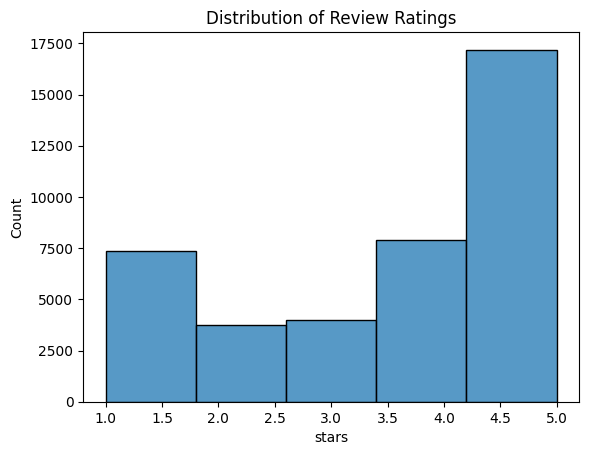

In [27]:
sns.histplot(df_review['stars'], bins=5)
plt.title("Distribution of Review Ratings")
plt.show()

In [28]:
top_restaurants_by_reviews = df_review['business_id'].value_counts().head(10)
top_restaurant_names = city_restaurants[city_restaurants['business_id'].isin(top_restaurants_by_reviews.index)]
top_restaurants_with_reviews = top_restaurant_names[['name', 'review_count']].set_index('name')
top_restaurants_with_reviews_sorted = top_restaurants_with_reviews.sort_values(by='review_count', ascending=False)

print("Top 10 Most Reviewed Restaurants Based on Review Count:")
print(top_restaurants_with_reviews_sorted)


Top 10 Most Reviewed Restaurants Based on Review Count:
                                    review_count
name                                            
Nugget Casino Resort                        1576
Sparks Coffee Shop                           807
Carlillos Cocina                             799
BJ's Nevada Barbecue                         702
Grimaldi's Pizzeria                          689
Ijji Sushi                                   623
BJ's Restaurant & Brewhouse                  621
Tha Joint Sushi & Grill                      597
Great Basin Brewing                          580
The Steak House at Western Village           544


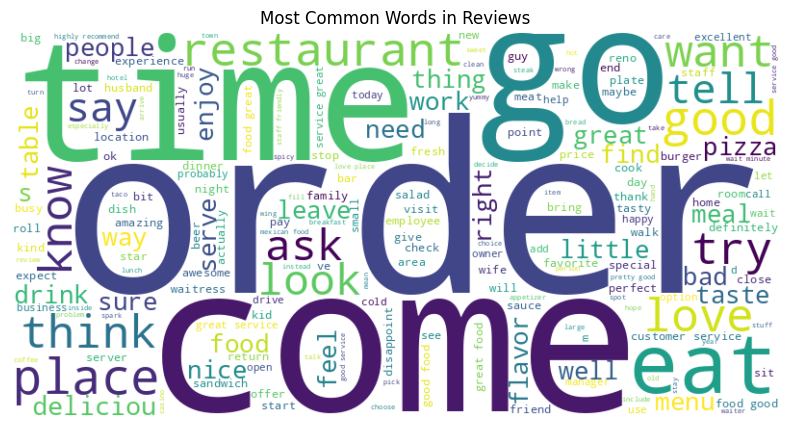

In [29]:
text_data = " ".join(df_review['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Reviews")
plt.show()

## Sentiment-Analysis

### Generate a sentiment analysis based on the review text of the user

In [30]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df_review['sentiment'] = df_review['clean_text'].apply(get_sentiment)

In [31]:
df_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,clean_text,sentiment
0,LkXdUnLG55HUqClm5C-FRQ,Bcwv94u7FgNCpCoJLmSsaA,l4aS1QVy_bGnwUXSJzpbsw,5.0,0,0,1,Best pizza ever... hands down.\n\nLove the pee...,2009-08-04 22:21:20,good pizza hand downlove peep run place hock...,0.270370
1,Z_tQ-hruQRU45Rg3XglyJQ,9wymgENHBBOm9Tlx7xHy7A,HZtkTPfSshfRjpQR7x1Raw,2.0,0,0,0,I didn't really like my sandwich I got here. I...,2014-03-14 23:13:32,not like sandwich get get jalapeo cheese bread...,-0.088333
2,r34W_h6NEMvBIpT2h53GQw,p0tP-O8y7rhJKd1iFirgwQ,t0XZeA0MP0P66QyLQn_NUw,5.0,0,0,0,This is a must get when you come to Reno is Ye...,2016-07-15 07:24:31,come reno yellow sub ask sprout sub will not r...,0.478571
3,P6Kbftcn5GwvIo2xQyXFBg,fSR8LJJ0Aa3w8HoaGyXYCA,UX3eq0WsVva-cqlVrzyzFg,5.0,0,0,0,"Yummy food, they will veganize things for you...",2013-12-28 22:22:19,yummy food veganize thing server friendly re...,0.481250
4,wXcsMgO27jDlr_8xuhn-pQ,CqRAt1eogaHCBBtF_shemg,ruFtZKwlJASx5BTk1dh5AQ,5.0,0,0,0,The new Bacon-Bleu cheeseburger is excellent! ...,2010-03-14 05:14:25,new baconbleu cheeseburger excellent probably ...,0.567273


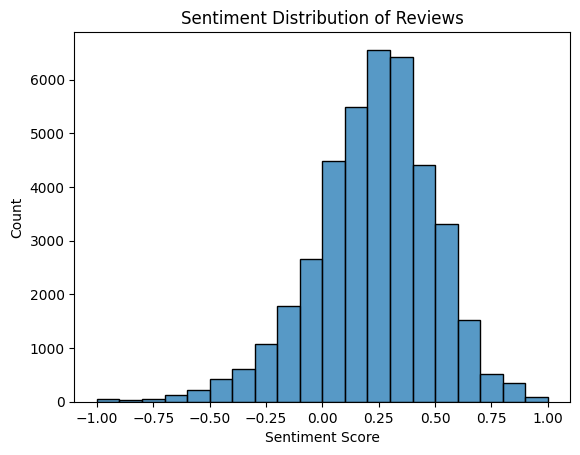

In [32]:
sns.histplot(df_review['sentiment'], bins=20)
plt.title("Sentiment Distribution of Reviews")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.show()

### Generate a new value that takes on account not only the sentiment of the user review, but also the star of the review

In [33]:
df_review['normalized_star'] = df_review['stars'] / 5.0
df_review['normalized_sentiment'] = (df_review['sentiment'] + 1) / 2

df_review['combined_sentiment'] = (df_review['normalized_star'] + df_review['normalized_sentiment']) / 2

In [34]:
df_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,clean_text,sentiment,normalized_star,normalized_sentiment,combined_sentiment
0,LkXdUnLG55HUqClm5C-FRQ,Bcwv94u7FgNCpCoJLmSsaA,l4aS1QVy_bGnwUXSJzpbsw,5.0,0,0,1,Best pizza ever... hands down.\n\nLove the pee...,2009-08-04 22:21:20,good pizza hand downlove peep run place hock...,0.270370,1.0,0.635185,0.817593
1,Z_tQ-hruQRU45Rg3XglyJQ,9wymgENHBBOm9Tlx7xHy7A,HZtkTPfSshfRjpQR7x1Raw,2.0,0,0,0,I didn't really like my sandwich I got here. I...,2014-03-14 23:13:32,not like sandwich get get jalapeo cheese bread...,-0.088333,0.4,0.455833,0.427917
2,r34W_h6NEMvBIpT2h53GQw,p0tP-O8y7rhJKd1iFirgwQ,t0XZeA0MP0P66QyLQn_NUw,5.0,0,0,0,This is a must get when you come to Reno is Ye...,2016-07-15 07:24:31,come reno yellow sub ask sprout sub will not r...,0.478571,1.0,0.739286,0.869643
3,P6Kbftcn5GwvIo2xQyXFBg,fSR8LJJ0Aa3w8HoaGyXYCA,UX3eq0WsVva-cqlVrzyzFg,5.0,0,0,0,"Yummy food, they will veganize things for you...",2013-12-28 22:22:19,yummy food veganize thing server friendly re...,0.481250,1.0,0.740625,0.870313
4,wXcsMgO27jDlr_8xuhn-pQ,CqRAt1eogaHCBBtF_shemg,ruFtZKwlJASx5BTk1dh5AQ,5.0,0,0,0,The new Bacon-Bleu cheeseburger is excellent! ...,2010-03-14 05:14:25,new baconbleu cheeseburger excellent probably ...,0.567273,1.0,0.783636,0.891818


## Simple User-Based Recommendation System

In [33]:
user_restaurant_matrix = df_review.pivot_table(
    index='user_id', 
    columns='business_id', 
    values='stars'
)

user_matrix_filled = user_restaurant_matrix.fillna(0)
user_similarity = cosine_similarity(user_matrix_filled)

user_similarity_df = pd.DataFrame(
    user_similarity, 
    index=user_restaurant_matrix.index, 
    columns=user_restaurant_matrix.index
)

def recommend_restaurants_for_user(target_user_id, top_n=5):
    if target_user_id not in user_similarity_df:
        return []

    similar_users = user_similarity_df[target_user_id].sort_values(ascending=False)[1:11]
    similar_users_ids = similar_users.index

    target_user_rated = user_restaurant_matrix.loc[target_user_id].dropna().index
    recommendations = user_restaurant_matrix.loc[similar_users_ids].mean().drop(target_user_rated, errors='ignore')
    top_recommendations = recommendations.sort_values(ascending=False).head(top_n)

    return city_restaurants[city_restaurants['business_id'].isin(top_recommendations.index)][['name', 'stars', 'review_count']]

## Sentiment-Enhanced Recommender System

### Data Preparation

In [35]:
user_restaurant_reviews = df_review[['user_id', 'business_id', 'stars', 'sentiment', 'text', 'normalized_star', 'normalized_sentiment', 'combined_sentiment']]
restaurant_details = city_restaurants[['business_id', 'name', 'review_count', 'categories']]
user_restaurant_reviews = user_restaurant_reviews.merge(restaurant_details, on='business_id')

In [36]:
user_restaurant_reviews.head()

,user_id,business_id,stars,sentiment,text,normalized_star,normalized_sentiment,combined_sentiment,name,review_count,categories
0,Bcwv94u7FgNCpCoJLmSsaA,l4aS1QVy_bGnwUXSJzpbsw,5.0,0.270370,Best pizza ever... hands down.\n\nLove the pee...,1.0,0.635185,0.817593,Big Apple Pizza & Subs,15,"Pizza, Restaurants"
1,9wymgENHBBOm9Tlx7xHy7A,HZtkTPfSshfRjpQR7x1Raw,2.0,-0.088333,I didn't really like my sandwich I got here. I...,0.4,0.455833,0.427917,Subway,9,"Sandwiches, Fast Food, Restaurants"
2,p0tP-O8y7rhJKd1iFirgwQ,t0XZeA0MP0P66QyLQn_NUw,5.0,0.478571,This is a must get when you come to Reno is Ye...,1.0,0.739286,0.869643,Yellow Submarine,231,"Restaurants, Sandwiches, Soup, Vegan"
3,fSR8LJJ0Aa3w8HoaGyXYCA,UX3eq0WsVva-cqlVrzyzFg,5.0,0.481250,"Yummy food, they will veganize things for you...",1.0,0.740625,0.870313,Cantina Los Tres Hombres,284,"Bars, Nightlife, Mexican, Restaurants, Seafood"
4,CqRAt1eogaHCBBtF_shemg,ruFtZKwlJASx5BTk1dh5AQ,5.0,0.567273,The new Bacon-Bleu cheeseburger is excellent! ...,1.0,0.783636,0.891818,Wendy's,35,"Fast Food, Restaurants, Hot Dogs, Burgers"


### Build a Hybrid Recommender System

#### Collaborative Filtering (User-User or Item-Item):

We can use a User-User Collaborative Filtering model, where users who liked similar restaurants are recommended new ones.

In [37]:
user_item_matrix = user_restaurant_reviews.pivot_table(index='user_id', columns='business_id', values='stars', aggfunc='mean')
user_item_matrix = user_item_matrix.fillna(0)
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

In [38]:
user_similarity_df.head()

user_id,--3Hl2oAvTPlq-f7KtogJg,--Vu3Gux9nPnLcG9yO_HxA,--f7c9Mlug2QcYA7aCzxYg,--hqkLaXma4waQO9zgYKWQ,--n_s-vHbCgMtqrEkW1CYw,-0PV67IzSBVVQfjpJ7VXtA,-0u2XBQzCIapX3sIJ6JUSQ,-1CSGQZ1973df_ij8p7hNQ,-1FEI9MF672Vr_sJv5jVwQ,-1GbffqNdHL6PoD6GNsS1Q,...,zyMvQ5m8llfnn9q0FluFTg,zykvrzkqA2UTem-H-EyfOw,zyu3o1B9ZPVr_VU-a3S9Cw,zyv6hqd1-XK3tlCLOYjYIw,zyvYRmeycKGa5BrFUFQncw,zzEVZIwU0gI1VQJtKgy3nA,zzLtAhFeZubESMkkgnBP9A,zzPyix8usTt0_w0uy7a4sg,zzXK3nZ8VwinaSTXVy7bPw,zzZIa5tJQIsG1eEXZ1cicQ
user_id,,,,,,,,,,,,,,,,,,,,,
--3Hl2oAvTPlq-f7KtogJg,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--Vu3Gux9nPnLcG9yO_HxA,0.0,1.000000,0.0,0.0,0.037276,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--f7c9Mlug2QcYA7aCzxYg,0.0,0.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--hqkLaXma4waQO9zgYKWQ,0.0,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--n_s-vHbCgMtqrEkW1CYw,0.0,0.037276,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Content-Based Filtering (Based on Sentiment & Restaurant Features):

Now, we’ll use a content-based filtering approach to recommend restaurants based on user sentiment and the attributes of restaurants (like categories, rating, and review count).

In [ ]:
restaurant_features = user_restaurant_reviews[['business_id', 'normalized_sentiment', 'stars', 'review_count', 'normalized_star', 'combined_sentiment']]
restaurant_features_matrix = restaurant_features[['normalized_sentiment', 'normalized_star', 'review_count']]
restaurant_similarity = cosine_similarity(restaurant_features_matrix)
restaurant_similarity_df = pd.DataFrame(restaurant_similarity, index=restaurant_features['business_id'], columns=restaurant_features['business_id'])

In [ ]:
restaurant_similarity_df.head()

#### Combine Collaborative Filtering and Content-Based Filtering:

In [ ]:
user_based_score = user_similarity_df.loc['user_id']
restaurant_based_score = restaurant_similarity_df.loc['restaurant_id'] 

combined_score = 0.5 * user_based_score + 0.5 * restaurant_based_score

top_restaurant_recommendations = combined_score.sort_values(ascending=False).head(10)

print("Top 10 Restaurant Recommendations:")
print(top_restaurant_recommendations)
